## Simple East West SST Trend Analysis for CMIP6

### Import packages

In [9]:
import intake
import pprint
import numpy as np
import util
import warnings
import xesmf as xe
import xarray as xr
import matplotlib.pyplot as plt

### Define some parameters

In [2]:
# CMIP Metadata
# These are defined as lists, but this code was written assuming one
# value in several places
var_ids = ['ts']  # variable to analyze
exp_ids = ['historical']  # experiment to analyze
table_ids = ["Amon"]  # table to use
activity_ids = ["CMIP"]  # activity to use
models_exclude = ['EC-Earth3', 'CESM2', 'MCM-UA-1-0']  # mis-behaving models [time axis issues]
catalog_json_file = "../catalogs/glade-cmip6.json"  # catalog file

# Analysis Options
start_year = 1979  # start of analysis period
end_year = 2014  # last year of analysis period
west_lat_bounds = [-2.5, 2.5]  # western pacific box lat bounds
west_lon_bounds = [117, 173]  # western pacific box lon bounds
east_lat_bounds = [-2.5, 2.5]  # eastern pacific box lat bounds
east_lon_bounds = [205, 275]  # eastern pacific box lon bounds

# This is mainly for this notebook, where the warnings are distracting.
# Show them once.
# warnings.filterwarnings(action='once') # I think this didn't work
warnings.filterwarnings('ignore')

### Create target grid for trend maps

In [3]:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-89, 90, 2.0)),
                     'lon': (['lon'], np.arange(1, 360, 1)),
                     }
                    )

### Search the catalog

In [4]:
col = intake.open_esm_datastore(catalog_json_file)
cat = col.search(activity_id=activity_ids, experiment_id=exp_ids,
                 variable_id=var_ids, table_id=table_ids)
uni_dict = cat.unique(['source_id', 'experiment_id', 'table_id'])
pprint.pprint(uni_dict, compact=True)

{'experiment_id': {'count': 1, 'values': ['historical']},
 'source_id': {'count': 26,
               'values': ['CNRM-CM6-1', 'CNRM-ESM2-1', 'BCC-ESM1',
                          'BCC-CSM2-MR', 'CESM2-WACCM', 'CESM2', 'FGOALS-g3',
                          'SAM0-UNICON', 'UKESM1-0-LL', 'HadGEM3-GC31-LL',
                          'GFDL-ESM4', 'GFDL-CM4', 'GISS-E2-1-H', 'GISS-E2-1-G',
                          'CanESM5', 'E3SM-1-0', 'CAMS-CSM1-0', 'MCM-UA-1-0',
                          'EC-Earth3', 'EC-Earth3-Veg', 'MRI-ESM2-0', 'NESM3',
                          'MIROC-ES2L', 'MIROC6', 'IPSL-CM6A-LR',
                          'NorESM2-LM']},
 'table_id': {'count': 1, 'values': ['Amon']}}


### Create CMIP6 dataset

In [5]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True,
                                             'decode_times': True},
                                cdf_kwargs={'chunks': {},
                                            'decode_times': True})


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 26 group(s)


### Pre-allocate some output 

In [6]:
modelList = [] # keep track of the model / realization
east_trends = [] # store all east pacific trends in a list
west_trends = [] # store all west pacific trends in a list
tropical_trends = [] # store all tropical trends in a list
global_trends = [] # store all global trends in a list
trend_maps = xr.Dataset() # xarray dataset to store trend maps

### Loop over all datasets and compute box statistics

In [7]:
# Loop over all datasets
for key in dset_dict.keys():
    ds = dset_dict[key]
    print(ds.source_id)
    # Skip misbehaving models
    if ds.source_id in models_exclude:
        continue
    # Loop over each ensemble member
    for j in range(len(ds.member_id)):
        m_id = ds.member_id[j].item()
        print('   ' + m_id, end=' ')
        dsvar = ds[var_ids[0]].isel(member_id=j)  # select data for variable
        # subset data in time
        dsvar = dsvar.sel(time=slice(str(start_year) + '-01-01',
                                     str(end_year) + '-12-30'))
        # get trend map
        trend_map = util.spatial_trends(dsvar)
        # regrid to common grid
        regridder = xe.Regridder(trend_map, ds_out, 'bilinear', reuse_weights=True)
        trend_regrid = regridder(trend_map)
        # get spatial average trends (from trend maps)
        m_west = util.simple_spatial_average(trend_regrid,
                                             lat_bounds=west_lat_bounds,
                                             lon_bounds=west_lon_bounds).item()
        m_east = util.simple_spatial_average(trend_regrid,
                                             lat_bounds=east_lat_bounds,
                                             lon_bounds=east_lon_bounds).item()
        m_tropics = util.simple_spatial_average(trend_regrid,
                                                lat_bounds=[-30, 30]).item()
        m_global = util.simple_spatial_average(trend_regrid).item()
        # store data in lists
        modelList.append([ds.source_id, m_id])  # store model / member
        trend_maps[ds.source_id + '_' + m_id] = trend_regrid
        east_trends.append(m_east)
        west_trends.append(m_west)
        tropical_trends.append(m_tropics)
        global_trends.append(m_global)
        print('')
    print()

BCC-CSM2-MR
   r2i1p1f1 Reuse existing file: bilinear_160x320_90x359.nc

   r1i1p1f1 Reuse existing file: bilinear_160x320_90x359.nc

   r3i1p1f1 Reuse existing file: bilinear_160x320_90x359.nc


BCC-ESM1
   r2i1p1f1 Reuse existing file: bilinear_64x128_90x359.nc

   r1i1p1f1 Reuse existing file: bilinear_64x128_90x359.nc

   r3i1p1f1 Reuse existing file: bilinear_64x128_90x359.nc


CAMS-CSM1-0
   r2i1p1f1 Reuse existing file: bilinear_160x320_90x359.nc

   r1i1p1f1 Reuse existing file: bilinear_160x320_90x359.nc


FGOALS-g3
   r1i1p1f1 Reuse existing file: bilinear_80x180_90x359.nc

   r2i1p1f1 Reuse existing file: bilinear_80x180_90x359.nc

   r3i1p1f1 Reuse existing file: bilinear_80x180_90x359.nc


CanESM5
   r2i1p1f1 Reuse existing file: bilinear_64x128_90x359.nc

   r5i1p1f1 Reuse existing file: bilinear_64x128_90x359.nc

   r12i1p1f1 Reuse existing file: bilinear_64x128_90x359.nc

   r1i1p2f1 Reuse existing file: bilinear_64x128_90x359.nc

   r14i1p2f1 Reuse existing file: bilin

### Create a box plot of the contrast in E-W trends

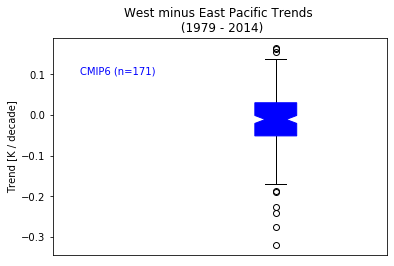

In [20]:
x = (np.array(west_trends)-np.array(east_trends))*10
inds = np.where(~np.isnan(x))[0]
x = x[inds]
plt.boxplot(x, notch=True, patch_artist=True, boxprops=dict(facecolor='blue', color='blue'), medianprops=dict(color='blue'))
plt.xticks([])
plt.xlim(0.2, 1.4)
plt.text(0.3, 0.1, 'CMIP6 (n=' + str(len(inds)) + ')', color='b')
# plt.text(0.3, 0.07, 'HadSST3 (n=100)', color='r')
plt.title('West minus East Pacific Trends \n (1979 - 2014)')
plt.ylabel('Trend [K / decade]')
plt.show()